In this second assignment, you are challenged to employ Hugging Face transformers for the same classification task as in the first assignment.

You should explore Hugging Face models to find a pre-trained model that is suitable and promising for fine-tuning with data for the ADU type classification task. It should make sense to pick one that has been pre-trained with Portuguese (either in isolation or in a multi-lingual fashion), possibly with data from a similar genre.

As a bonus, you can also employ a domain adaptation approach, by leveraging on the full text of opinion articles made available.

You should compare the performance of your model(s) with the ones developed for the first assignment. For the final delivery, prepare a short presentation (max 10 slides) documenting your approach.



## Loading the dataset 

In [ ]:
%ls

sample_data/


In [1]:
!pip install datasets
!pip install transformers
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 7.5 MB/s 
     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 43.2 MB/s 
     |████████████████████████████████| 86 kB 3.9 MB/s 
     |████████████████████████████████| 212 kB 52.7 MB/s 
     |████████████████████████████████| 140 kB 12.2 MB/s 
     |████████████████████████████████| 596 kB 46.5 MB/s 
     |████████████████████████████████| 127 kB 61.2 MB/s 
     |████████████████████████████████| 271 kB 49.6 MB/s 
     |████████████████████████████████| 144 kB 59.2 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 112 kB 74.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing ins

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/OpArticles_ADUs.xlsx")
translated_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/translated_spans.csv")
dataset.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


## Data cleaning

Some text spans were annotated more than once. In these cases, there are 2 possibilities:


1.   The text span is kept, if all annotations consider that the example belongs to the same class; 
2.   The text span is eliminated, if different annotators assign different labels to the example. 



In [4]:
import numpy as np

grouped_df = dataset.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": [], "article_id": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    if len(dict_counts.keys()) > 1:
        continue
    dataset_dict["article_id"].append(group["article_id"].values[0])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(list(dict_counts.keys())[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label", "article_id"])
dataset.head()

,tokens,label,article_id
0,presumo que essas partilhas tenham gerado um e...,Value,5cdd971b896a7fea062d6e3d
1,essas partilhas tenham gerado um efeito bola d...,Value,5cdd971b896a7fea062d6e3d
2,esta questão ter [justificadamente] despertado...,Value,5cdd971b896a7fea062d6e3d
3,a ocasião propicia um debate amplo na sociedad...,Value,5cdd971b896a7fea062d6e3d
4,a tomada urgente de medidas por parte da tutel...,Value,5cdd971b896a7fea062d6e3d


In [6]:
dataset["label"].value_counts()

Value       5003
Fact        2235
Value(-)    1768
Value(+)     849
Policy       398
Name: label, dtype: int64

The dataset is now ready for splitting. Without any augmentation, it contains roughly 10.000 samples. Similarly to assignment 1, it is unbalanced, having significantly more "Value" examples.

In order to easily use and split the dataset, we need to convert it into a Hugging Face dataset.

In [5]:
from datasets import Dataset

labels = ['Value','Fact','Value(+)','Value(-)','Policy']
numeric_labels = []

for label in dataset["label"]:
    new_label = labels.index(label)
    numeric_labels.append(new_label)

dataset["label"] = numeric_labels
#dataset["tokens"] = translated_dataset["Translated Spans"]
dataset_hf = Dataset.from_pandas(dataset)
dataset

,tokens,label,article_id
0,presumo que essas partilhas tenham gerado um e...,0,5cdd971b896a7fea062d6e3d
1,essas partilhas tenham gerado um efeito bola d...,0,5cdd971b896a7fea062d6e3d
2,esta questão ter [justificadamente] despertado...,0,5cdd971b896a7fea062d6e3d
3,a ocasião propicia um debate amplo na sociedad...,0,5cdd971b896a7fea062d6e3d
4,a tomada urgente de medidas por parte da tutel...,0,5cdd971b896a7fea062d6e3d
...,...,...,...
10248,Um presidente de câmara pode pertencer à admin...,0,5d04c671896a7fea06a11275
10249,eticamente é reprovável,3,5d04c671896a7fea06a11275
10250,"eticamente é reprovável e, o bom senso, aconse...",0,5d04c671896a7fea06a11275
10251,"o bom senso, aconselha a não o fazer",0,5d04c671896a7fea06a11275


## Splitting the dataset

We can now split the dataset into training, testing and validating sets.

In [6]:
from datasets import DatasetDict

# 90% train, 10% test+validation
train_test = dataset_hf.train_test_split(test_size=0.1)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

BERTimbau Base is a pretrained BERT model for Brazilian Portuguese that achieves state-of-the-art performances on three downstream NLP tasks: Named Entity Recognition, Sentence Textual Similarity and Recognizing Textual Entailment. It is available in two sizes: Base and Large.

## Load Train function

In [7]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import AutoModelForSequenceClassification

from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)



# training_args = TrainingArguments("test_trainer", num_train_epochs=1)


def load_train(model_name, tokenizer_name):
  
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False, padding=True, truncation=True, model_max_len=512)


  
  def preprocess_function(sample):
    return tokenizer(sample["tokens"], truncation=True, padding=True)

  tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

  training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True,
  )


  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
  )
  return trainer


## Metrics Function

In [11]:
import torch
from transformers import TextClassificationPipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def metrics(model_name):
  
  tokenizer2 = AutoTokenizer.from_pretrained(model_name)
  model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
  pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2)

  def preprocess_function(sample):
    return tokenizer2(sample["tokens"], truncation=True, padding=True)

  tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

  y_pred= []
  for p in tokenized_dataset['test']['tokens']:
      ti = tokenizer2(p, return_tensors="pt")
      out = model2(**ti)
      pred = torch.argmax(out.logits)
      y_pred.append(pred.item())



  y_test = tokenized_dataset['test']['label']

  #print(confusion_matrix(y_test, y_pred))
  print('Accuracy: ', accuracy_score(y_test, y_pred))
  print('Precision: ', precision_score(y_test, y_pred, average='macro'))
  print('Recall: ', recall_score(y_test, y_pred, average='macro'))
  print('F1: ', f1_score(y_test, y_pred, average='macro'))

  cm = confusion_matrix(y_test, y_pred, labels = [0,1,2,3,4])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()

## neuralmind/bert-base-portuguese-**cased**

In [ ]:
trainer = load_train("neuralmind/bert-base-portuguese-cased", "neuralmind/bert-base-portuguese-cased")
trainer.train()
trainer.save_model()

loading configuration file https://huggingface.co/neuralmind/bert-base-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e716e2151985ba669e7197b64cdde2552acee146494d40ffaf0688a3f152e6ed.18a0b8b86f3ebd4c8a1d8d6199178feae9971ff5420f1d12f0ed8326ffdff716
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.067300,0.870493,0.647173
2,0.774100,0.866070,0.666667
3,0.609300,0.920512,0.653021


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to neuralmind/bert-base-portuguese-cased/checkpoint-577
Configuration saved in neuralmind/bert-base-portuguese-cased/checkpoint-577/config.json
Model weights saved in neuralmind/bert-base-portuguese-cased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in neuralmind/bert-base-portuguese-cased/checkpoint-577/tokenizer_config.json
Special tokens file saved in neuralmind/bert-base-portuguese-cased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If t

TrainOutput(global_step=1731, training_loss=0.7838993259828811, metrics={'train_runtime': 811.3719, 'train_samples_per_second': 34.116, 'train_steps_per_second': 2.133, 'total_flos': 2200529999598756.0, 'train_loss': 0.7838993259828811, 'epoch': 3.0})

Didn't find file neuralmind/bert-base-portuguese-cased/added_tokens.json. We won't load it.
loading file neuralmind/bert-base-portuguese-cased/vocab.txt
loading file neuralmind/bert-base-portuguese-cased/tokenizer.json
loading file None
loading file neuralmind/bert-base-portuguese-cased/special_tokens_map.json
loading file neuralmind/bert-base-portuguese-cased/tokenizer_config.json
loading configuration file neuralmind/bert-base-portuguese-cased/config.json
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-base-portuguese-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6335282651072125
Precision:  0.6207460317460318
Recall:  0.5664364329444106
F1:  0.5882114655699079


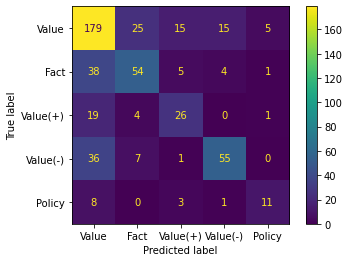

In [ ]:

metrics("neuralmind/bert-base-portuguese-cased")

##neuralmind/bert-large-portuguese-cased

In [ ]:
trainer = load_train("neuralmind/bert-large-portuguese-cased", "neuralmind/bert-large-portuguese-cased")
trainer.train()
trainer.save_model()

https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmphg0_k8zg


Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
creating metadata file for /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-large-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/016fb7702039667c9fb9dd2ceffaf04027b13e525a6248cda2a4a87dbb8687af.881d7200bce807f871637ac9d552c541b2d4b00146a0bf1ab0360f3640031273
creating metadata file for /root/.cache/huggingface/transformers/016fb7702039667c9fb9dd2ceffaf04027b13e525a6248cda2a4a87dbb8687af.881d7200bce807f871637ac9d552c541b2d4b00146a0bf1ab0360f3640031273
loading weights file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/016fb7702039667c9fb9dd2ceffaf04027b13e525a6248cda2a4a87dbb8687af.881d7200bce807f871637ac9d552c541b2d4b00146a0bf1ab0360f3640031273
Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/3a44fa9a74e90f509368a7f2789df38e1fedd153a52c62ef5cc5f4b0f5c99c2a.d61b68f744aef2741575c270d4ba0228cd35693bfa15d8babfb5c1079062d5d7
creating metadata file for /root/.cache/huggingface/transformers/3a44fa9a74e90f509368a7f2789df38e1fedd153a52c62ef5cc5f4b0f5c99c2a.d61b68f744aef2741575c270d4ba0228cd35693bfa15d8babfb5c1079062d5d7
loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-large-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": 

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/9cfcd25de0a333b1b5f4a3db227e93a806cfb041d93a49221eeaee6773eaa41c.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/9cfcd25de0a333b1b5f4a3db227e93a806cfb041d93a49221eeaee6773eaa41c.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvpg0etjx


Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/6a3aa038873b8f0d0ab3a4de0a658f063b89e3afd815920a5f393c0e4ae84259.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
creating metadata file for /root/.cache/huggingface/transformers/6a3aa038873b8f0d0ab3a4de0a658f063b89e3afd815920a5f393c0e4ae84259.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp1u6ap7bg


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/d5b721c156180bbbcc4a1017e8c72a18f8f96cdc178acec5ddcd45905712b4cf.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/d5b721c156180bbbcc4a1017e8c72a18f8f96cdc178acec5ddcd45905712b4cf.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9cfcd25de0a333b1b5f4a3db227e93a806cfb041d93a49221eeaee6773eaa41c.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/added_tokens.json from cache

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.024100,0.880449,0.643275
2,0.699400,0.933392,0.660819
3,0.481500,1.051708,0.629630


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to neuralmind/bert-large-portuguese-cased/checkpoint-577
Configuration saved in neuralmind/bert-large-portuguese-cased/checkpoint-577/config.json
Model weights saved in neuralmind/bert-large-portuguese-cased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in neuralmind/bert-large-portuguese-cased/checkpoint-577/tokenizer_config.json
Special tokens file saved in neuralmind/bert-large-portuguese-cased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id.

Didn't find file neuralmind/bert-large-portuguese-cased/added_tokens.json. We won't load it.
loading file neuralmind/bert-large-portuguese-cased/vocab.txt
loading file neuralmind/bert-large-portuguese-cased/tokenizer.json
loading file None
loading file neuralmind/bert-large-portuguese-cased/special_tokens_map.json
loading file neuralmind/bert-large-portuguese-cased/tokenizer_config.json
loading configuration file neuralmind/bert-large-portuguese-cased/config.json
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-large-portuguese-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6432748538011696
Precision:  0.6395987933634993
Recall:  0.5569106830917658
F1:  0.5869513533687648


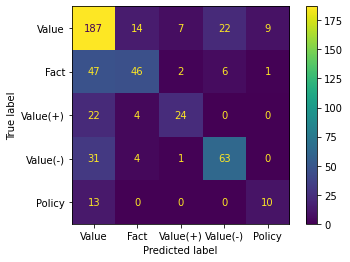

In [ ]:
metrics("neuralmind/bert-large-portuguese-cased")

## Geotrend/distilbert-base-pt-cased

In [ ]:
trainer = load_train("Geotrend/distilbert-base-pt-cased", "Geotrend/distilbert-base-pt-cased")
trainer.train()
trainer.save_model()

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239M [00:00<?, ?B/s]

Some weights of the model checkpoint at Geotrend/distilbert-base-pt-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-pt-cased and are newly initialized: ['classifier.bias', 'pre_classifier.

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/158k [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1731


Epoch,Training Loss,Validation Loss,Accuracy
1,1.204800,1.081461,0.559454
2,0.986500,1.046536,0.596491
3,0.848500,1.083224,0.576998


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to Geotrend/distilbert-base-pt-cased/checkpoint-577
Configuration saved in Geotrend/distilbert-base-pt-cased/checkpoint-577/config.json
Model weights saved in Geotrend/distilbert-base-pt-cased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in Geotrend/distilbert-base-pt-cased/checkpoint-577/tokenizer_config.json
Special tokens file saved in Geotrend/distilbert-base-pt-cased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tok

Didn't find file Geotrend/distilbert-base-pt-cased/added_tokens.json. We won't load it.
loading file Geotrend/distilbert-base-pt-cased/vocab.txt
loading file Geotrend/distilbert-base-pt-cased/tokenizer.json
loading file None
loading file Geotrend/distilbert-base-pt-cased/special_tokens_map.json
loading file Geotrend/distilbert-base-pt-cased/tokenizer_config.json
loading configuration file Geotrend/distilbert-base-pt-cased/config.json
Model config DistilBertConfig {
  "_name_or_path": "Geotrend/distilbert-base-pt-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "mode

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.5828460038986355
Precision:  0.5094269530148783
Recall:  0.4656688531107136
F1:  0.47357642923041626


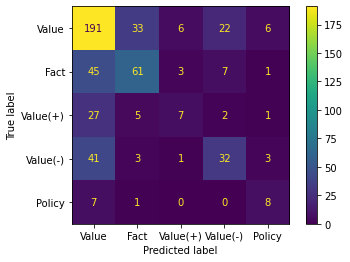

In [ ]:
metrics("Geotrend/distilbert-base-pt-cased")

## monilouise/ner_news_portuguese

In [ ]:
trainer = load_train("monilouise/ner_news_portuguese", "monilouise/ner_news_portuguese")
trainer.train()
trainer.save_model()

loading configuration file https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ee9b506d42deb9a1fde19bb7f40f64da74a2b871a58bfbfa55ccf29281aa9476.08868e7914995036411ed3728b7e905ee94d69938262ad30ffe4e5dac473f090
Model config BertConfig {
  "_name_or_path": "monilouise/ner_news_portuguese",
  "_num_labels": 13,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "L-ORG",
    "1": "O",
    "2": "I-PESSOA",
    "3": "I-ORG",
    "4": "B-PUB",
    "5": "L-PUB",
    "6": "I-LOC",
    "7": "B-PESSOA",
    "8": "L-LOC",
    "9": "B-LOC",
    "10": "B-ORG",
    "11": "L-PESSOA",
    "12": "I-PUB"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LO

Downloading:   0%|          | 0.00/529 [00:00<?, ?B/s]

storing https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/416f056519145ab1e46205df8e68bb2f810904409cdee6c25e4b9537974ef822.c8e627eef86d8864ea5006f2bddab4afa35fd3470a139cda6261c1b3cc594c5b
creating metadata file for /root/.cache/huggingface/transformers/416f056519145ab1e46205df8e68bb2f810904409cdee6c25e4b9537974ef822.c8e627eef86d8864ea5006f2bddab4afa35fd3470a139cda6261c1b3cc594c5b
loading configuration file https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ee9b506d42deb9a1fde19bb7f40f64da74a2b871a58bfbfa55ccf29281aa9476.08868e7914995036411ed3728b7e905ee94d69938262ad30ffe4e5dac473f090
Model config BertConfig {
  "_name_or_path": "monilouise/ner_news_portuguese",
  "_num_labels": 13,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "direction

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/c26f3d92dbac7a353ade4229653b3ef2ef17593a8f65385179bdbb3e8d9eee42.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/c26f3d92dbac7a353ade4229653b3ef2ef17593a8f65385179bdbb3e8d9eee42.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp8wf6vtsz


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/1f34b39d29ae7725a693d0363461d30c1f8fcff2bca357a22dae0a712817c2ba.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/1f34b39d29ae7725a693d0363461d30c1f8fcff2bca357a22dae0a712817c2ba.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/c26f3d92dbac7a353ade4229653b3ef2ef17593a8f65385179bdbb3e8d9eee42.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/monilouise/ner_news_portuguese/resolve/main/added_tokens.json from cache at None
loading file https://hu

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.167100,0.883896,0.643275
2,0.803300,0.904511,0.651072
3,0.630700,0.952371,0.625731


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to monilouise/ner_news_portuguese/checkpoint-577
Configuration saved in monilouise/ner_news_portuguese/checkpoint-577/config.json
Model weights saved in monilouise/ner_news_portuguese/checkpoint-577/pytorch_model.bin
tokenizer config file saved in monilouise/ner_news_portuguese/checkpoint-577/tokenizer_config.json
Special tokens file saved in monilouise/ner_news_portuguese/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected 

Didn't find file monilouise/ner_news_portuguese/added_tokens.json. We won't load it.
loading file monilouise/ner_news_portuguese/vocab.txt
loading file monilouise/ner_news_portuguese/tokenizer.json
loading file None
loading file monilouise/ner_news_portuguese/special_tokens_map.json
loading file monilouise/ner_news_portuguese/tokenizer_config.json
loading configuration file monilouise/ner_news_portuguese/config.json
Model config BertConfig {
  "_name_or_path": "monilouise/ner_news_portuguese",
  "_num_labels": 13,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "L-ORG",
    "1": "O",
    "2": "I-PESSOA",
    "3": "I-ORG",
    "4": "B-PUB",
    "5": "L-PUB",
    "6": "I-LOC",
    "7": "B-PESSOA",
    "8": "L-LOC",
    "9": "B-LOC",
    "10": "B

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6140350877192983
Precision:  0.6027967354283142
Recall:  0.5255800397148512
F1:  0.5531525482775402


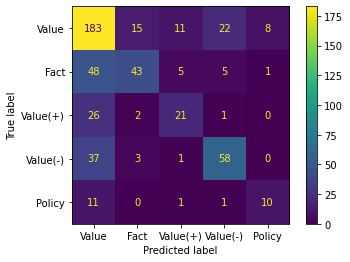

In [ ]:
metrics("monilouise/ner_news_portuguese")

## Edresson/wav2vec2-large-xlsr-coraa-portuguese

In [ ]:
trainer = load_train("mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt", "mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt")
trainer.train()
trainer.save_model()

https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpht984g5x


Downloading:   0%|          | 0.00/691 [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/1d529c6ee54900d845d5d5222bb74b3dd741a56f5fe4c7efcee5709b7e3fd603.9d4b8349ec24ff9b8a111458fba26f6b9aa8bf7794bf65b45676e410c26c4cd8
creating metadata file for /root/.cache/huggingface/transformers/1d529c6ee54900d845d5d5222bb74b3dd741a56f5fe4c7efcee5709b7e3fd603.9d4b8349ec24ff9b8a111458fba26f6b9aa8bf7794bf65b45676e410c26c4cd8
loading configuration file https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1d529c6ee54900d845d5d5222bb74b3dd741a56f5fe4c7efcee5709b7e3fd603.9d4b8349ec24ff9b8a111458fba26f6b9aa8bf7794bf65b45676e410c26c4cd8
Model config BertConfig {
  "_name_or_path": "mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/a40aa76c8f21aa4fd5ec01bcf7f1da1982f94b73880e13587829fbb06e800630.f2f13529f67f7fd23e405638255beb5d73bd046585431ca63c65ad41697078ec
creating metadata file for /root/.cache/huggingface/transformers/a40aa76c8f21aa4fd5ec01bcf7f1da1982f94b73880e13587829fbb06e800630.f2f13529f67f7fd23e405638255beb5d73bd046585431ca63c65ad41697078ec
loading weights file https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a40aa76c8f21aa4fd5ec01bcf7f1da1982f94b73880e13587829fbb06e800630.f2f13529f67f7fd23e405638255beb5d73bd046585431ca63c65ad41697078ec
Some weights of the model checkpoint at mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt were not used when initializing BertForSequenceClassification: ['qa_outputs.bias', 'qa_outputs.

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8456b4dd2844300f18a7ee2b84e42cafb59f679e7fb7b1ff81990bfbde73c12c.013f6c164a99ea850de70d8e2b540caee3882e8a91f77f5b5b10e560941276dd
creating metadata file for /root/.cache/huggingface/transformers/8456b4dd2844300f18a7ee2b84e42cafb59f679e7fb7b1ff81990bfbde73c12c.013f6c164a99ea850de70d8e2b540caee3882e8a91f77f5b5b10e560941276dd
loading configuration file https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/1d529c6ee54900d845d5d5222bb74b3dd741a56f5fe4c7efcee5709b7e3fd603.9d4b8349ec24ff9b8a111458fba26f6b9aa8bf7794bf65b45676e410c26c4cd8
Model config BertConfig {
  "_name_or_path": "mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/7ece669edbbb2512ccf2608abf7ef8ba931b0c958672341d7f4302a1d5bdf995.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/7ece669edbbb2512ccf2608abf7ef8ba931b0c958672341d7f4302a1d5bdf995.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpt1odflta


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/0e2bbcdb8498a6141699b34b3290645cb45fc841250a11ba6bc34041b185b746.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/0e2bbcdb8498a6141699b34b3290645cb45fc841250a11ba6bc34041b185b746.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/7ece669edbbb2512ccf2608abf7ef8ba931b0c958672341d7f4302a1d5bdf995.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/mrm8488/bert-base-portugue

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.052100,0.901937,0.610136
2,0.760000,0.909676,0.645224
3,0.575300,0.995395,0.627680


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/checkpoint-577
Configuration saved in mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/checkpoint-577/config.json
Model weights saved in mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/checkpoint-577/pytorch_model.bin
tokenizer config file saved in mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/checkpoint-577/tokenizer_config.json
Special tokens file saved in mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argu

Didn't find file mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/added_tokens.json. We won't load it.
loading file mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/vocab.txt
loading file mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/tokenizer.json
loading file None
loading file mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/special_tokens_map.json
loading file mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/tokenizer_config.json
loading configuration file mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt/config.json
Model config BertConfig {
  "_name_or_path": "mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LAB

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6159844054580896
Precision:  0.6056388901256444
Recall:  0.5552416026415748
F1:  0.5710547838793169


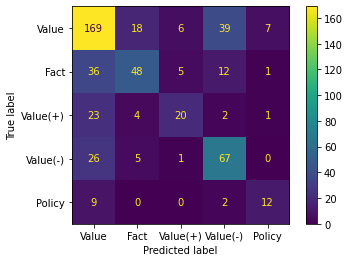

In [ ]:
metrics("mrm8488/bert-base-portuguese-cased-finetuned-squad-v1-pt")

## ricardo-filho/bert-base-portuguese-cased-finetuned-ner

In [ ]:
trainer = load_train("ricardo-filho/bert-base-portuguese-cased-finetuned-ner", "ricardo-filho/bert-base-portuguese-cased-finetuned-ner")
trainer.train()
trainer.save_model()

loading configuration file https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/516ca7cf70c6ee646264fcf387d7e63b4acf913f4ab45139af15112f30e10401.2c5a2797d8efadeaf1c9a1ce53be0aaa8b872662e5cd089701ffe873da15bab9
Model config BertConfig {
  "_name_or_path": "ricardo-filho/bert-base-portuguese-cased-finetuned-ner",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "

Downloading:   0%|          | 0.00/530 [00:00<?, ?B/s]

storing https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/5cf26906681cfe6de59286f9407a002e6871ce6df0a8bc5344fd0ce6c583076c.44ba356a4a6293d6f10691edc7f7efa18e72f4345b5ae5a09689a41cc02023b6
creating metadata file for /root/.cache/huggingface/transformers/5cf26906681cfe6de59286f9407a002e6871ce6df0a8bc5344fd0ce6c583076c.44ba356a4a6293d6f10691edc7f7efa18e72f4345b5ae5a09689a41cc02023b6
https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp96m316j1


Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/833883373bfad6624e9687e5366521e650eacf3f3444bdb35b57f5d007c8256d.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/833883373bfad6624e9687e5366521e650eacf3f3444bdb35b57f5d007c8256d.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpvaboyvtw


Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

storing https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/3669d589c4e167f4705262a114cb3769c869c5e2b9ab34b97e165226cdf0689e.91dcee4cd95491b853dd6840c5b649662400e640055fc8420941b94230b798fe
creating metadata file for /root/.cache/huggingface/transformers/3669d589c4e167f4705262a114cb3769c869c5e2b9ab34b97e165226cdf0689e.91dcee4cd95491b853dd6840c5b649662400e640055fc8420941b94230b798fe
https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpva9on1pg


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/d14b8e8f5b3c4cfa90fafe44ef68273315ecd9ceedd002fbec183854d28b7bc0.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/d14b8e8f5b3c4cfa90fafe44ef68273315ecd9ceedd002fbec183854d28b7bc0.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/833883373bfad6624e9687e5366521e650eacf3f3444bdb35b57f5d007c8256d.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/ricardo-filho/bert-base-portuguese-cased-finetuned-ner/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/3669d589c4e167f4705262a114cb3769c86

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.185100,0.888058,0.653021
2,0.802300,0.888795,0.651072
3,0.635500,0.942779,0.637427


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to ricardo-filho/bert-base-portuguese-cased-finetuned-ner/checkpoint-577
Configuration saved in ricardo-filho/bert-base-portuguese-cased-finetuned-ner/checkpoint-577/config.json
Model weights saved in ricardo-filho/bert-base-portuguese-cased-finetuned-ner/checkpoint-577/pytorch_model.bin
tokenizer config file saved in ricardo-filho/bert-base-portuguese-cased-finetuned-ner/checkpoint-577/tokenizer_config.json
Special tokens file saved in ricardo-filho/bert-base-portuguese-cased-finetuned-ner/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `B

Didn't find file ricardo-filho/bert-base-portuguese-cased-finetuned-ner/added_tokens.json. We won't load it.
loading file ricardo-filho/bert-base-portuguese-cased-finetuned-ner/vocab.txt
loading file ricardo-filho/bert-base-portuguese-cased-finetuned-ner/tokenizer.json
loading file None
loading file ricardo-filho/bert-base-portuguese-cased-finetuned-ner/special_tokens_map.json
loading file ricardo-filho/bert-base-portuguese-cased-finetuned-ner/tokenizer_config.json
loading configuration file ricardo-filho/bert-base-portuguese-cased-finetuned-ner/config.json
Model config BertConfig {
  "_name_or_path": "ricardo-filho/bert-base-portuguese-cased-finetuned-ner",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
  

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6120857699805068
Precision:  0.5982047138749162
Recall:  0.5232692229575664
F1:  0.5484891888974656


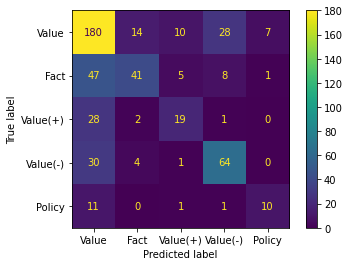

In [ ]:
metrics("ricardo-filho/bert-base-portuguese-cased-finetuned-ner")

## Babelscape/wikineural-multilingual-ner

In [ ]:
trainer = load_train("Babelscape/wikineural-multilingual-ner", "Babelscape/wikineural-multilingual-ner")
trainer.train()
trainer.save_model()

loading configuration file https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/250d6d05947bc92116cb81c914c294c9b53adcc701b874552d6e487498fda862.519134046b20d960f618f04804ebfc858ec4641c3a0ce637636c37b2cc9db268
Model config BertConfig {
  "_name_or_path": "Babelscape/wikineural-multilingual-ner",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 5,
    "B-MISC": 7,
    "B-ORG": 3,
    "B-PER": 1,
    "I-LOC": 6,
    "I-MISC": 8,
    "I-ORG": 4,
    "I-PER": 2,
 

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

storing https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/96509a0e4ea98a5b9fe5c881e9f055d5534f7db0900bb3a65c11b03cb57a005e.6848769198472b1552f036ec41fce4fc67ed44f2d96a24dda14daf2b1fce11de
creating metadata file for /root/.cache/huggingface/transformers/96509a0e4ea98a5b9fe5c881e9f055d5534f7db0900bb3a65c11b03cb57a005e.6848769198472b1552f036ec41fce4fc67ed44f2d96a24dda14daf2b1fce11de
https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmps5wn56gy


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0d18a5a6b432ec223de99d2814e92e7205f06d0950b512c22473d6e90aead966.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/0d18a5a6b432ec223de99d2814e92e7205f06d0950b512c22473d6e90aead966.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp9j2hxkyi


Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

storing https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/df307a423431fa0a537738086974a79e49e673d93f2aedcb48e2946a64fcbc13.ffced7571a04701785584b8bfa0d118bd6bfacd5aeb48016c1a6e2139aa4b65a
creating metadata file for /root/.cache/huggingface/transformers/df307a423431fa0a537738086974a79e49e673d93f2aedcb48e2946a64fcbc13.ffced7571a04701785584b8bfa0d118bd6bfacd5aeb48016c1a6e2139aa4b65a
https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmponp4zjxn


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/1abc6b399547f8a06ede3332d1ce934ba316a264f0746324b0e2395451d7e17b.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/1abc6b399547f8a06ede3332d1ce934ba316a264f0746324b0e2395451d7e17b.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0d18a5a6b432ec223de99d2814e92e7205f06d0950b512c22473d6e90aead966.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/Babelscape/wikineural-multilingual-ner/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/df307a423431fa0a537738086974a79e49e673d93f2aedcb48e2946a64fcbc13.ffced7571a04701785

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.222100,1.088518,0.576998
2,0.941500,1.078918,0.575049
3,0.770100,1.120169,0.555556


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id. If tokens, article_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to Babelscape/wikineural-multilingual-ner/checkpoint-577
Configuration saved in Babelscape/wikineural-multilingual-ner/checkpoint-577/config.json
Model weights saved in Babelscape/wikineural-multilingual-ner/checkpoint-577/pytorch_model.bin
tokenizer config file saved in Babelscape/wikineural-multilingual-ner/checkpoint-577/tokenizer_config.json
Special tokens file saved in Babelscape/wikineural-multilingual-ner/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens, article_id.

Didn't find file Babelscape/wikineural-multilingual-ner/added_tokens.json. We won't load it.
loading file Babelscape/wikineural-multilingual-ner/vocab.txt
loading file Babelscape/wikineural-multilingual-ner/tokenizer.json
loading file None
loading file Babelscape/wikineural-multilingual-ner/special_tokens_map.json
loading file Babelscape/wikineural-multilingual-ner/tokenizer_config.json
loading configuration file Babelscape/wikineural-multilingual-ner/config.json
Model config BertConfig {
  "_name_or_path": "Babelscape/wikineural-multilingual-ner",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-PER",
    "2": "I-PER",
    "3": "B-ORG",
    "4": "I-ORG",
    "5": "B-LOC",
    "6": "I-LOC",
    "7": "B-MISC",
    "8": "I-MISC"
  },
  "initializer_range": 0.02,
 

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.5730994152046783
Precision:  0.578711154895103
Recall:  0.4855231206434537
F1:  0.5147409848988728


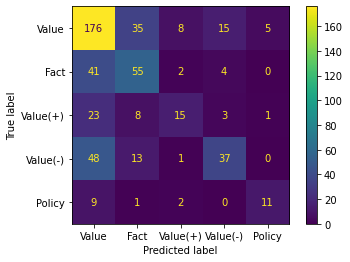

In [ ]:
metrics("Babelscape/wikineural-multilingual-ner")

## lfcc/bert-base-pt-archive

In [ ]:
trainer = load_train("lfcc/bert-base-pt-archive", "lfcc/bert-base-pt-archive")
trainer.train()
trainer.save_model()

Downloading:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lfcc/bert-base-pt-archive and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/544 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1731


Epoch,Training Loss,Validation Loss,Accuracy
1,1.097500,0.986696,0.623782
2,0.784800,1.008171,0.612086
3,0.642900,1.113658,0.612086


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to lfcc/bert-base-pt-archive/checkpoint-577
Configuration saved in lfcc/bert-base-pt-archive/checkpoint-577/config.json
Model weights saved in lfcc/bert-base-pt-archive/checkpoint-577/pytorch_model.bin
tokenizer config file saved in lfcc/bert-base-pt-archive/checkpoint-577/tokenizer_config.json
Special tokens file saved in lfcc/bert-base-pt-archive/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassi

Didn't find file lfcc/bert-base-pt-archive/added_tokens.json. We won't load it.
loading file lfcc/bert-base-pt-archive/vocab.txt
loading file lfcc/bert-base-pt-archive/tokenizer.json
loading file None
loading file lfcc/bert-base-pt-archive/special_tokens_map.json
loading file lfcc/bert-base-pt-archive/tokenizer_config.json
loading configuration file lfcc/bert-base-pt-archive/config.json
Model config BertConfig {
  "_name_or_path": "lfcc/bert-base-pt-archive",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-Organizacao",
    "2": "I-Local",
    "3": "B-Local",
    "4": "B-Pessoa",
    "5": "I-Profissao",
    "6": "B-Profissao",
    "7": "B-Data",
    "8": "I-Data",
    "9": "I-Pessoa",
    "10": "I-Organizacao"
  },
  "initiali

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6101364522417154
Precision:  0.6011203475380735
Recall:  0.5415867539278684
F1:  0.5650058994947393


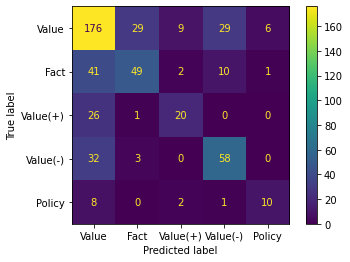

In [ ]:
metrics("lfcc/bert-base-pt-archive")

## lfcc/bert-large-pt-archive

In [ ]:
trainer = load_train("lfcc/bert-large-pt-archive", "lfcc/bert-large-pt-archive")
trainer.train()
trainer.save_model()

https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp3hmw2d19


Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/eed44e1e263cc958e92f6912ecae5a70d55c9a9581e4585306bddb6e2caf7372.f41946214bc598e5bb99cc241feb62fa41d8ce7b3c635711865be77ef3b6c73b
creating metadata file for /root/.cache/huggingface/transformers/eed44e1e263cc958e92f6912ecae5a70d55c9a9581e4585306bddb6e2caf7372.f41946214bc598e5bb99cc241feb62fa41d8ce7b3c635711865be77ef3b6c73b
loading configuration file https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/eed44e1e263cc958e92f6912ecae5a70d55c9a9581e4585306bddb6e2caf7372.f41946214bc598e5bb99cc241feb62fa41d8ce7b3c635711865be77ef3b6c73b
Model config BertConfig {
  "_name_or_path": "lfcc/bert-large-pt-archive",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing":

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/c4c3efa34376fb2cd560ff1f528181f29cef59eacf6c99ea96af8e6eb0f0863f.501fa97ded505981a6fd3264150419a935445cbf34be53955ae177715858b4f5
creating metadata file for /root/.cache/huggingface/transformers/c4c3efa34376fb2cd560ff1f528181f29cef59eacf6c99ea96af8e6eb0f0863f.501fa97ded505981a6fd3264150419a935445cbf34be53955ae177715858b4f5
loading weights file https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/c4c3efa34376fb2cd560ff1f528181f29cef59eacf6c99ea96af8e6eb0f0863f.501fa97ded505981a6fd3264150419a935445cbf34be53955ae177715858b4f5
All model checkpoint weights were used when initializing BertForSequenceClassification.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lfcc/bert-large-pt-archive and are newly initialized: ['bert.pooler

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/11d7f96ee5e4e50a3c1bcada97719b29b2bf5b8cccdbc08951268c7a5a167ee2.933ba08ce5cdaf53684bb64033175616559e06d9adc8d8b0849f0100002bb0fc
creating metadata file for /root/.cache/huggingface/transformers/11d7f96ee5e4e50a3c1bcada97719b29b2bf5b8cccdbc08951268c7a5a167ee2.933ba08ce5cdaf53684bb64033175616559e06d9adc8d8b0849f0100002bb0fc
https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpk4d_hzhs


Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/ae93579993eee5377ab45aaa9e8a7a4975c8169a6b228ee0e98393658a7ab443.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/ae93579993eee5377ab45aaa9e8a7a4975c8169a6b228ee0e98393658a7ab443.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplwi1g6z1


Downloading:   0%|          | 0.00/428k [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/cc97df4e34f95af69eba94f3b9d4bc56e3b8db9ed837cbc447b8136f2f3949ec.bead6e693fc57dabf1a0c6bbace6df0c4786ff9ce738636f684366f4eb938eb2
creating metadata file for /root/.cache/huggingface/transformers/cc97df4e34f95af69eba94f3b9d4bc56e3b8db9ed837cbc447b8136f2f3949ec.bead6e693fc57dabf1a0c6bbace6df0c4786ff9ce738636f684366f4eb938eb2
https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpf2a0k719


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/10d4338bba711d0eaaa546801e9468610759d4869a82b6dee341249a8aed6f9f.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/10d4338bba711d0eaaa546801e9468610759d4869a82b6dee341249a8aed6f9f.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/ae93579993eee5377ab45aaa9e8a7a4975c8169a6b228ee0e98393658a7ab443.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/lfcc/bert-large-pt-archive/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/cc97df4e34f95af69eba94f3b9d4bc56e3b8db9ed837cbc447b8136f2f3949ec.bead6e693fc57dabf1a0c6bbace6df0c4786ff9ce738636f684366

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.029700,0.907255,0.647173
2,0.686200,0.934019,0.654971
3,0.494000,1.085183,0.641326


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to lfcc/bert-large-pt-archive/checkpoint-577
Configuration saved in lfcc/bert-large-pt-archive/checkpoint-577/config.json
Model weights saved in lfcc/bert-large-pt-archive/checkpoint-577/pytorch_model.bin
tokenizer config file saved in lfcc/bert-large-pt-archive/checkpoint-577/tokenizer_config.json
Special tokens file saved in lfcc/bert-large-pt-archive/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceC

Didn't find file lfcc/bert-large-pt-archive/added_tokens.json. We won't load it.
loading file lfcc/bert-large-pt-archive/vocab.txt
loading file lfcc/bert-large-pt-archive/tokenizer.json
loading file None
loading file lfcc/bert-large-pt-archive/special_tokens_map.json
loading file lfcc/bert-large-pt-archive/tokenizer_config.json
loading configuration file lfcc/bert-large-pt-archive/config.json
Model config BertConfig {
  "_name_or_path": "lfcc/bert-large-pt-archive",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_r

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6257309941520468
Precision:  0.6315818568602073
Recall:  0.5588294609971819
F1:  0.5848605961090458


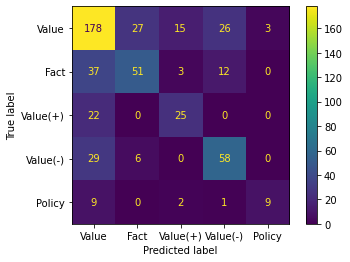

In [ ]:
metrics("lfcc/bert-large-pt-archive")

## lfcc/bert-multilingual-pt-archive

In [ ]:
trainer = load_train("lfcc/bert-multilingual-pt-archive", "lfcc/bert-multilingual-pt-archive")
trainer.train()
trainer.save_model()

https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpv0xmx2iz


Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/5fc3faad34ea4711420e4f5206839796a5f15cc07f639fa23cf1773fb9f196ab.aabacd959a714383b834dd17d83133d9e66bb768bfe3d167c8fac6805d2f1e7b
creating metadata file for /root/.cache/huggingface/transformers/5fc3faad34ea4711420e4f5206839796a5f15cc07f639fa23cf1773fb9f196ab.aabacd959a714383b834dd17d83133d9e66bb768bfe3d167c8fac6805d2f1e7b
loading configuration file https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/5fc3faad34ea4711420e4f5206839796a5f15cc07f639fa23cf1773fb9f196ab.aabacd959a714383b834dd17d83133d9e66bb768bfe3d167c8fac6805d2f1e7b
Model config BertConfig {
  "_name_or_path": "lfcc/bert-multilingual-pt-archive",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gra

Downloading:   0%|          | 0.00/676M [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9881761845ebee491c214ae195af5e28e029a9ca607d5c3217bce923c70cde36.f424012b6520847744ea35d20db4178366db31f8b8cc0a8ee8bc7a0f07e6a43a
creating metadata file for /root/.cache/huggingface/transformers/9881761845ebee491c214ae195af5e28e029a9ca607d5c3217bce923c70cde36.f424012b6520847744ea35d20db4178366db31f8b8cc0a8ee8bc7a0f07e6a43a
loading weights file https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9881761845ebee491c214ae195af5e28e029a9ca607d5c3217bce923c70cde36.f424012b6520847744ea35d20db4178366db31f8b8cc0a8ee8bc7a0f07e6a43a
All model checkpoint weights were used when initializing BertForSequenceClassification.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lfcc/bert-multilingual-pt-archive and are newly initi

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/900892de9befa532e723fed2e890ce7ffb1167aae2db6cc92d630f617d25d134.6848769198472b1552f036ec41fce4fc67ed44f2d96a24dda14daf2b1fce11de
creating metadata file for /root/.cache/huggingface/transformers/900892de9befa532e723fed2e890ce7ffb1167aae2db6cc92d630f617d25d134.6848769198472b1552f036ec41fce4fc67ed44f2d96a24dda14daf2b1fce11de
https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkwbtxmhb


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/b339dc1ad9dfc7b0b7b99e604133f46eea38ca11ddb68b76251f27102516df13.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
creating metadata file for /root/.cache/huggingface/transformers/b339dc1ad9dfc7b0b7b99e604133f46eea38ca11ddb68b76251f27102516df13.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwn5unf3t


Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/6f2d2abaac47bd130e1907ddf4cbc69e2fd57ec7e4604625faa9ba591893444b.5218319a250cc5800e902092d64f3bfb0d8fc55b761081e03b93b756707502f3
creating metadata file for /root/.cache/huggingface/transformers/6f2d2abaac47bd130e1907ddf4cbc69e2fd57ec7e4604625faa9ba591893444b.5218319a250cc5800e902092d64f3bfb0d8fc55b761081e03b93b756707502f3
https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp6b1pypec


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/a0c1fbb52f7c69b16da6055e21a934f1a443015acad14ad3a79e54050df30fc2.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/a0c1fbb52f7c69b16da6055e21a934f1a443015acad14ad3a79e54050df30fc2.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b339dc1ad9dfc7b0b7b99e604133f46eea38ca11ddb68b76251f27102516df13.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/lfcc/bert-multilingual-pt-archive/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/6f2d2abaac47bd130e1907ddf4cbc69e2fd57ec7e4604625faa9ba591893444b.5218319a250cc5800e902092d64f3bfb0

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.215300,1.125789,0.563353
2,0.951700,1.131142,0.555556
3,0.816100,1.221299,0.547758


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to lfcc/bert-multilingual-pt-archive/checkpoint-577
Configuration saved in lfcc/bert-multilingual-pt-archive/checkpoint-577/config.json
Model weights saved in lfcc/bert-multilingual-pt-archive/checkpoint-577/pytorch_model.bin
tokenizer config file saved in lfcc/bert-multilingual-pt-archive/checkpoint-577/tokenizer_config.json
Special tokens file saved in lfcc/bert-multilingual-pt-archive/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens ar

Didn't find file lfcc/bert-multilingual-pt-archive/added_tokens.json. We won't load it.
loading file lfcc/bert-multilingual-pt-archive/vocab.txt
loading file lfcc/bert-multilingual-pt-archive/tokenizer.json
loading file None
loading file lfcc/bert-multilingual-pt-archive/special_tokens_map.json
loading file lfcc/bert-multilingual-pt-archive/tokenizer_config.json
loading configuration file lfcc/bert-multilingual-pt-archive/config.json
Model config BertConfig {
  "_name_or_path": "lfcc/bert-multilingual-pt-archive",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABE

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.5458089668615984
Precision:  0.5436353003721425
Recall:  0.3948066333704361
F1:  0.43295732696275496


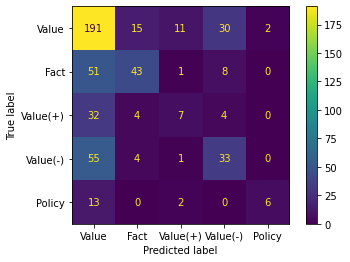

In [ ]:
metrics("lfcc/bert-multilingual-pt-archive")

In [9]:
trainer = load_train("bert-base-multilingual-uncased", "bert-base-multilingual-uncased")
trainer.train()
trainer.save_model()

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1731


Epoch,Training Loss,Validation Loss,Accuracy
1,1.212800,1.144688,0.532164
2,1.019100,1.153059,0.538012
3,0.856800,1.199617,0.541910


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to bert-base-multilingual-uncased/checkpoint-577
Configuration saved in bert-base-multilingual-uncased/checkpoint-577/config.json
Model weights saved in bert-base-multilingual-uncased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in bert-base-multilingual-uncased/checkpoint-577/tokenizer_config.json
Special tokens file saved in bert-base-multilingual-uncased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected 

Didn't find file bert-base-multilingual-uncased/added_tokens.json. We won't load it.
loading file bert-base-multilingual-uncased/vocab.txt
loading file bert-base-multilingual-uncased/tokenizer.json
loading file None
loading file bert-base-multilingual-uncased/special_tokens_map.json
loading file bert-base-multilingual-uncased/tokenizer_config.json
loading configuration file bert-base-multilingual-uncased/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.571150097465887
Precision:  0.4149377147766324
Recall:  0.33738766980146295
F1:  0.35113976310937156


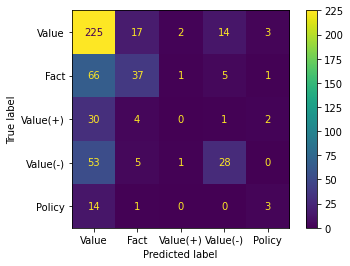

In [12]:
metrics("bert-base-multilingual-uncased")

## bert-finetuned-articles

Use the checkpoint obtained from domain adaptation

In [13]:
trainer = load_train("/content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles", "neuralmind/bert-large-portuguese-cased")
trainer.train()
trainer.save_model()

loading configuration file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/3a44fa9a74e90f509368a7f2789df38e1fedd153a52c62ef5cc5f4b0f5c99c2a.d61b68f744aef2741575c270d4ba0228cd35693bfa15d8babfb5c1079062d5d7
creating metadata file for /root/.cache/huggingface/transformers/3a44fa9a74e90f509368a7f2789df38e1fedd153a52c62ef5cc5f4b0f5c99c2a.d61b68f744aef2741575c270d4ba0228cd35693bfa15d8babfb5c1079062d5d7
https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpd4fep0rx


Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
creating metadata file for /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
loading configuration file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c534071830642050813fa94003dbf1234413b3f1d5dc66d259fbc82ff7d5fd59.c8340a82acfbbcd2dd960b86d2886ee120b21896ef0294150f0391918ae6ced5
Model config BertConfig {
  "_name_or_path": "neuralmind/bert-large-portuguese-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/9cfcd25de0a333b1b5f4a3db227e93a806cfb041d93a49221eeaee6773eaa41c.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
creating metadata file for /root/.cache/huggingface/transformers/9cfcd25de0a333b1b5f4a3db227e93a806cfb041d93a49221eeaee6773eaa41c.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp3ty2r3n9


Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/6a3aa038873b8f0d0ab3a4de0a658f063b89e3afd815920a5f393c0e4ae84259.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
creating metadata file for /root/.cache/huggingface/transformers/6a3aa038873b8f0d0ab3a4de0a658f063b89e3afd815920a5f393c0e4ae84259.5cc6e825eb228a7a5cfd27cb4d7151e97a79fb962b31aaf1813aa102e746584b
https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpsl1l8ncv


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/d5b721c156180bbbcc4a1017e8c72a18f8f96cdc178acec5ddcd45905712b4cf.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/d5b721c156180bbbcc4a1017e8c72a18f8f96cdc178acec5ddcd45905712b4cf.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9cfcd25de0a333b1b5f4a3db227e93a806cfb041d93a49221eeaee6773eaa41c.af25fb1e29ad0175300146695fd80069be69b211c52fa5486fa8aae2754cc814
loading file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/neuralmind/bert-large-portuguese-cased/resolve/main/added_tokens.json from cache

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.033100,0.934030,0.606238
2,0.758700,0.952870,0.631579
3,0.595900,1.042225,0.627680


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/checkpoint-577
Configuration saved in /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/checkpoint-577/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/checkpoint-577/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/checkpoint-577/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab No

Didn't find file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/added_tokens.json. We won't load it.
loading file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/vocab.txt
loading file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/tokenizer.json
loading file None
loading file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/special_tokens_map.json
loading file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/tokenizer_config.json
loading configuration file /content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention

  0%|          | 0/10 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.6354775828460039
Precision:  0.5718441971383148
Recall:  0.5327231306541652
F1:  0.5387991217708545


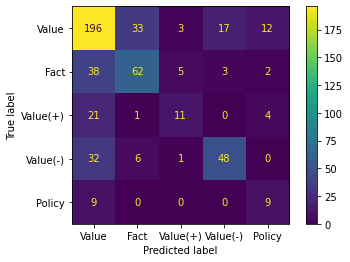

In [14]:
metrics("/content/drive/MyDrive/Colab Notebooks/models/bert-base-portuguese-cased-finetuned-articles")

## Zero-shot classification



In [ ]:
zs_clf = pipeline("zero-shot-classification")

labels = ['Value','Fact','Value(+)','Value(-)','Policy']

y_pred = []

def predict_span(span):
    results = zs_clf(span, labels)
    zip_res = list(zip(results['scores'], results['labels']))
    prediction = max(zip_res, key=lambda x: x[0])
    return prediction[1]

for row in translated_spans.iterrows():
    y_pred.append(predict_span(row[1]["Translated Spans"]))
    print(len(y_pred)*100/10253)
    

len(y_pred)